### QTW Case Study 5 - Missing Data Analysis with California Housing Data
### Jayson Barker, Brandon Croom, Shane Weinstock

## Business Understanding

#### Missing data (or missing values) occur when no data value is stored for a variable in an observation. To have missing data in a dataset is a common occurrence which can have profound effects on drawable conclusions from that data. There are several problems that can stem from having missing data in a dataset. First, missing data reduces statistical power, which refers to the probability that the hypothesis test will reject the null hypothesis when it is false. Second, missing data can cause bias in the estimations of parameters. Third, the representativeness of the sample used in analysis is reduced by missing data. Fourth, missing data may complicate the analysis by forcing the analyst to make assumptions on how to work with the data. Each of these distortions may threaten the validity of the conclusions.

#### There are three types of missing data that typically occur in data sets. The definitions of these three types is based on the reasons the data is missing.

#### Missing completely at random (MCAR) is defined as data that is missing without any specific reason; that is if the events that lead to any particular data being missing are independent both of observable variables and unobservable parameters of interest, and are entirely at random. MCAR data does allow any analysis to be unbiased given the random nature of the missing values. In practice, MCAR data is rare.

#### Missing at random (MAR) occurs whe the missingness of the data is not random, but when it can be fully accounted for by observations with complete information. An example, of MAR would be a study on IQ and income, if participants with above average IQs tend to skip questions related to salary, analysis that do not take this into account may find a false relationship between IQ and salary. MAR data can introduce parameter bias if not detected. 

#### Missing not at random (MNAR) data occurs when there is a reason the data is missing. Extending on the example above if those with high IQs failed to answer the salary questions because of their IQ's the missingness of the salary data could be classified as MNAR

#### Over the course of this report, we will leverage the California Housing data set provided as a part of the SKLearn package to show the impacts of these types of missing data on analysis. A baseline linear regression model will be built on the data set. Then the various missing data classifications will be executed on the data and the model re-evaluated to show the impacts on the model when compared to the baseline model. 

#### For those readers who want to understand the code used in this notebook, click the "Show Inputs" button below to display all of the cells containing code used in this analysis. Re-running the Jupyter cell will hide the code again.

In [1]:
# Run me to hide code cells

from IPython.core.display import display, HTML
display(HTML(r"""<style id=hide>div.input{display:none;}</style><button type="button"onclick="var myStyle = document.getElementById('hide').sheet;myStyle.insertRule('div.input{display:inherit !important;}', 0);">Show inputs</button>"""))

## Data Analysis

#### The California Housing data set is provided as part of the SKLearn package. Based on the description from the SKLearn website (https://scikit-learn.org/stable/datasets/index.html#real-world-datasets), the data set was obtained from the StatLib repository. The data set was derived from the 1990 US census. Each row in the data set is equal to a census block group. A block group is the smallest geographical unit that the US Census Bureau publishes sample data. The typical population in a block group is between 600 and 3000 people. The dataset contains 20,640 samples, 8 continuous features and no missing values. The features defined in the data are:

- MedInc - Median Income in block
- HouseAge - Median house age in block
- AveRooms - Average number of rooms
- AveBedrms - Average number of bedrooms
- Population - Block population
- AveOccup - Average house occupancy
- Latitude - House Block Latitude
- Longitude - House Block Longitude

#### After loading the data set summary statistics are gathered for a quick analysis. The target variable is not initially inluded in the dataset and has been combined into the dataframe to obtain summary statistics.

#### A quick review of these summary statistics shows that for the most part values seem reasonable. The counts in each feature column match the counts specified by the SKLearn library definition. Max values on a few columns (AveRooms, AveBedrms, and AveOccup) look suspect as they seem extremely high. These may need further investigation.

In [2]:
%%capture warn
import numpy as np
import os
import tarfile
import pandas as pd
from sklearn.datasets import california_housing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics
from sklearn.metrics import r2_score,adjusted_rand_score
from sklearn.impute import SimpleImputer 
import ipywidgets as widgets
from IPython import display
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def getModelMetrics(testType, percentData, y_test, y_pred):

    metricNames = ['r2_score',
              'mean_squared_error',
              'explained_variance_score', 
              'mean_absolute_error',
              'median_absolute_error'
                 ]
    regMetrics = [sklearn.metrics.r2_score,
                  sklearn.metrics.mean_squared_error,
                  sklearn.metrics.explained_variance_score, 
                  sklearn.metrics.mean_absolute_error,
                  sklearn.metrics.median_absolute_error
                 ]

    scores = {}
    
    scores['Test'] = testType
    scores['Percent'] = percentData
    
    for name, metric in zip(metricNames, regMetrics):
        scores[name] = round(metric(y_test, y_pred),3)
        
    return pd.DataFrame([scores])

In [4]:
# build a full results dataframe
df_results = []

# download data and store to a data frame
data = california_housing.fetch_california_housing()
df = pd.DataFrame(data= data.data, columns=data.feature_names)

# Fetch prices from the dataset
p=data.target

#converting prices to it's own dataframe for use later on in the split
p_df=pd.DataFrame({"prices":p})

#concatenating both dataframes to get the complete dataset
calf_hous_df = pd.concat([df,p_df],axis=1)

# Complete dataset
calf_hous_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,prices
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


#### Now that summary analysis has been performed on the dataset, a check to verify that are are truly no missing values will occur. With the outut below, we can confirm that there are no missing values in any of the features or target variable of the data set.

In [5]:
# check for nulls
calf_hous_df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
prices        0
dtype: int64

#### As an additional check, data correlation needs to be evaluated. Evaluating correlation allows for teasing out any colinear variables that may need to be removed from the model to improve performance. The heatmap below shows the correlation between features. AveRooms and AveBedrms are potentially collinear and may warrant removal from the model.

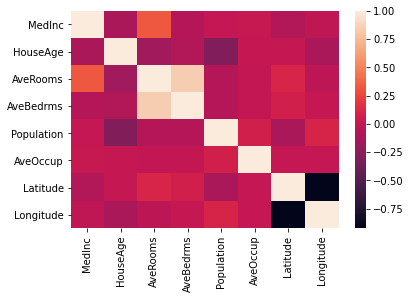

In [6]:
# Correlation heatmap
sns.heatmap(df.corr())

## Linear Regression Baseline Model

####  Building a linear regression model to predict the housing price will provide a baseline model to compare against. This is a very simplistic model that provides a starting point and something to compare to as we move further along in the analysis.

#### The data is initially split using an 80/20 train-test split. This produces a training data set of 16,512 rows x 8 columns. The corresponding predictor training set is also 16,512 rows x 1 column (prices).

#### Using the test/train split data a linear regression model will be run to see how well housing prices can be predicted. The model will be evaluated on the R-squared metric. R-squared evalates the scatter of the data points around the fitted regression line. R-squared values are always between 0 and 100%. A value of 0% represents a model that does not explain any of the variation in the response variable, while a value of 100% represents a model that explains all of the variation in the response variable. As a model comparison metric the larger the R-squared metric the better the model. In addition to R-Squared metrics, other model metrics will also be captured and analyzed across all of the models. 

#### For the baseline linear regression model, the R-squared score is 33.4% (~0.3340). Given the low value this may not be the best model for predicting housing prices in California and further model manipulation may be required.

In [7]:
# Split training and test data set using an 80/20 split
calf_hous_df_2 = calf_hous_df[calf_hous_df.columns[~calf_hous_df.columns.isin(['prices'])]]

x_train,x_test,y_train,y_test=train_test_split(calf_hous_df_2,p_df,test_size=0.2,random_state=7)

In [8]:
%%capture x_train_capt
x_train.shape

In [9]:
%%capture y_train_capt
y_train.shape

In [10]:
%%capture lin_reg_capt
# train the linear regression model
baseline_model = LinearRegression()
baseline_model.fit(x_train,y_train)

In [11]:
# predict using the test data
baseline_model_pred = baseline_model.predict(x_test)

In [12]:
# How accuratge is our baseline model? Let's return the R2 score
df_results

r2_baseline = r2_score(baseline_model_pred,y_test)
df_results.append(getModelMetrics('Baseline',0, baseline_model_pred, y_test))
    
# 0.334 is a pretty poor score for a baseline model. Can we do better?

## Missing Data Analysis

#### In order to show the impact that missing data can have on models, the next few sections will evaluate the baseline linear regression model against the three missing data scenarios:

    * Missing Completely At Random (MCAR)
    * Missing At Random (MAR)
    * Missing Not At Random (MNAR)

#### Each of these scenarios will show the impact these missing data scenarios has on model performance based on how the missing values are handled.

### Missing Completely At Random (MCAR) Analysis

#### For the Missing Completely at Random analysis a single column, for this analysis HouseAge,  will be manipulated to replace 1%, 5%, 10%, 20%, 33% and 50% of the original data values with NaN at random. Once the data values for the various percentages have been randomly set to NaN, data imputation will be performed to "fill in" the missing values. The imputation method used on the HouseAge column will be using the mean value of the house age. Using the mean as the imputation method allows for maintaining the sample size and is relatively easy to perform. 

#### As a comparison metric for each of the imputation percentages the R-Squared metric will be used. It is expected that as the imputation percentage increases the R-Squared metric should decrease due to less variability in the data. 

#### The outputs below allow for ensuring data is manipulated based on the individual percentages defined above. The expectation is the percentages will be relatively close for the analysis with no large discrepancies.

In [13]:
# Hold 1% of the records constant and replace with NAN
df2 = calf_hous_df.copy()

df2_1 = df.copy()
df2_1.HouseAge[df2_1.HouseAge.sample(frac=(1/100)).index] = np.nan  

# Hold 5% of the records constant and replace with NAN
df2_5 = df.copy()
df2_5.HouseAge[df2_5.HouseAge.sample(frac=(5/100)).index] = np.nan 

# Hold 10% of the records constant and replace with NAN
df2_10 = df.copy()
df2_10.HouseAge[df2_10.HouseAge.sample(frac=(10/100)).index] = np.nan 

# Hold 20% of the records constant and replace with NAN
df2_20 = df.copy()
df2_20.HouseAge[df2_20.HouseAge.sample(frac=(20/100)).index] = np.nan 

# Hold 33% of the records constant and replace with NAN
df2_33 = df.copy()
df2_33.HouseAge[df2_33.HouseAge.sample(frac=(33/100)).index] = np.nan 

# Hold 50% of the records constant and replace with NAN
df2_50 = df.copy()
df2_50.HouseAge[df2_50.HouseAge.sample(frac=(50/100)).index] = np.nan 


In [14]:
# Check baseline for NAs - 1%
print('Baseline NAs for 1%')
print((df2_1.isna().sum()/len(df2_1))*100)

Baseline NAs for 1%
MedInc        0.000000
HouseAge      0.998062
AveRooms      0.000000
AveBedrms     0.000000
Population    0.000000
AveOccup      0.000000
Latitude      0.000000
Longitude     0.000000
dtype: float64


In [15]:
# Check baseline for NAs - 5%
print('Baseline NAs for 5%')
print((df2_5.isna().sum()/len(df2_5))*100)

Baseline NAs for 5%
MedInc        0.0
HouseAge      5.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
dtype: float64


In [16]:
# Check baseline for NAs - 10%
print('Baseline NAs for 10%')
print((df2_10.isna().sum()/len(df2_10))*100)

Baseline NAs for 10%
MedInc         0.0
HouseAge      10.0
AveRooms       0.0
AveBedrms      0.0
Population     0.0
AveOccup       0.0
Latitude       0.0
Longitude      0.0
dtype: float64


In [17]:
# Check baseline for NAs - 20%
print('Baseline NAs for 20%')
print((df2_20.isna().sum()/len(df2_20))*100)

Baseline NAs for 20%
MedInc         0.0
HouseAge      20.0
AveRooms       0.0
AveBedrms      0.0
Population     0.0
AveOccup       0.0
Latitude       0.0
Longitude      0.0
dtype: float64


In [18]:
# Check baseline for NAs - 33%
print('Baseline NAs for 33%')
print((df2_33.isna().sum()/len(df2_33))*100)

Baseline NAs for 33%
MedInc         0.000000
HouseAge      32.999031
AveRooms       0.000000
AveBedrms      0.000000
Population     0.000000
AveOccup       0.000000
Latitude       0.000000
Longitude      0.000000
dtype: float64


In [19]:
# Check baseline for NAs - 50%
print('Baseline NAs for 50%')
print((df2_50.isna().sum()/len(df2_50))*100)

Baseline NAs for 50%
MedInc         0.0
HouseAge      50.0
AveRooms       0.0
AveBedrms      0.0
Population     0.0
AveOccup       0.0
Latitude       0.0
Longitude      0.0
dtype: float64


In [20]:
%%capture impute_cap
# Impute for the NANs and replace with the mean

# Impute NANs - 1%
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df2_1)
imputer.transform(df2_1)

# Impute NANs - 5%
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df2_5)
imputer.transform(df2_5)

# Impute NANs - 10%
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df2_10)
imputer.transform(df2_10)

# Impute NANs - 20%
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df2_20)
imputer.transform(df2_20)

# Impute NANs - 33%
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df2_33)
imputer.transform(df2_33)

# Impute NANs - 50%
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df2_50)
imputer.transform(df2_50)

In [21]:
# Replace existing HouseAge column with imputed column - 1%
df2['HouseAge'] = df2_1['HouseAge']
df2_v1 = df2[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df2_v1_p = df2[['prices']]

# Split 1%
x_train,x_test,y_train,y_test=train_test_split(df2_v1,df2_v1_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_1 = r2_score(impute_model_pred,y_test)

df_results.append(getModelMetrics('MCAR',1, impute_model_pred, y_test))

In [22]:
# Replace existing HouseAge column with imputed column - 5%
df2['HouseAge'] = df2_5['HouseAge']
df2_v5 = df2[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df2_v5_p = df2[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df2_v5,df2_v5_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_5 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MCAR',5, impute_model_pred, y_test))


In [23]:
# Replace existing HouseAge column with imputed column - 10%
df2['HouseAge'] = df2_10['HouseAge']
df2_v10 = df2[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df2_v10_p = df2[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df2_v10,df2_v10_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_10 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MCAR',10, impute_model_pred, y_test))

In [24]:
# Replace existing HouseAge column with imputed column - 20%
df2['HouseAge'] = df2_20['HouseAge']
df2_v20 = df2[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df2_v20_p = df2[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df2_v20,df2_v20_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_20 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MCAR',20, impute_model_pred, y_test))

In [25]:
# Replace existing HouseAge column with imputed column - 33%
df2['HouseAge'] = df2_33['HouseAge']
df2_v33 = df2[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df2_v33_p = df2[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df2_v33,df2_v33_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_33 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MCAR',33, impute_model_pred, y_test))

In [26]:
# Replace existing HouseAge column with imputed column - 50%
df2['HouseAge'] = df2_50['HouseAge']
df2_v50 = df2[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df2_v50_p = df2[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df2_v50,df2_v50_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_50 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MCAR',50, impute_model_pred, y_test))

#### The table below shows the R-Squared results for each of the percentages of data imputation for the MCAR analysis. As expected the more data that is imputed the lower the R-Squared value. 

| Imputation |   |   R-Squared |
|:----------:|:-:|:---------:|
|     1%     |   | 33.4%     |
|     5%     |   | 33.5%     |
|     10%    |   | 33.1%     |
|     20%    |   | 32.9%     |
|     33%    |   | 32.5%     |
|     50%    |   | 31.6%     |

#### When compared to the baseline model R-Squared of 33.4% everything seems to be inline with the exception of the 5% imputation model. As more of the missing data is replaced with the mean the data values in the HouseAge column become more alike and thus the R-Squared values decrease. At 1% imputation this does not have a huge impact and is inline with the baseline model. At 50% imputation there is an impact and the R-Squared metrics differ. Comparing the MCAR models across themselves the impact of the imputation is evident as the values drop as more data is imputed. 


### Missing At Random (MAR) Analysis

#### For the Missing At Random (MAR) Analysis two different columns will be selected and data will be missing at random when controlled for by a third column. For example, if variable Z is > 30, then variables X and Y are randomly missing). The analysis will be performed on data percentages of 10%, 20% and 20% of missing data. These data sets will then be fit to the linear regression model and compared against the baseline model. 

#### In order to create the missing at random data the HouseAge and AveRoom columns were selected as the columns to make randomly missing. These columns will be marked missing based on the population field. If the population is greater than 1425, the mean of the population field,  then the HouseAge and AveRoom columns will be marked as missing. As was done previously, the mean will be used as the imputation method for the missing data. 

#### The outputs below allow for ensuring data is manipulated based on the individual percentages defined above. The expectation is the percentages will be relatively close for the analysis with no large discrepancies.

In [27]:
filter_var = df2.Population >= 1425
cols_var = ['HouseAge','AveRooms']

# 10% run
df3 = df2.copy()

df3_10 = df2.copy()
df3_10.loc[df3_10.loc[filter_var].sample(frac=(10/100)).index, cols_var] = np.nan

# Check baseline for NAs - 10%
print('Baseline NAs for 10%')
print((df3_10.isna().sum()/len(df3_10))*100)
print('')

# 20% run
df3 = df2.copy()

df3_20 = df2.copy()
df3_20.loc[df3_20.loc[filter_var].sample(frac=(20/100)).index, cols_var] = np.nan

# Check baseline for NAs - 20%
print('Baseline NAs for 20%')
print((df3_20.isna().sum()/len(df3_20))*100)
print('')

# 30% run
df3 = df2.copy()

df3_30 = df2.copy()
df3_30.loc[df3_30.loc[filter_var].sample(frac=(30/100)).index, cols_var] = np.nan

# Check baseline for NAs - 30%
print('Baseline NAs for 30%')
print((df3_30.isna().sum()/len(df3_30))*100)
print('')

Baseline NAs for 10%
MedInc        0.000000
HouseAge      3.643411
AveRooms      3.643411
AveBedrms     0.000000
Population    0.000000
AveOccup      0.000000
Latitude      0.000000
Longitude     0.000000
prices        0.000000
dtype: float64

Baseline NAs for 20%
MedInc        0.000000
HouseAge      7.286822
AveRooms      7.286822
AveBedrms     0.000000
Population    0.000000
AveOccup      0.000000
Latitude      0.000000
Longitude     0.000000
prices        0.000000
dtype: float64

Baseline NAs for 30%
MedInc         0.000000
HouseAge      10.935078
AveRooms      10.935078
AveBedrms      0.000000
Population     0.000000
AveOccup       0.000000
Latitude       0.000000
Longitude      0.000000
prices         0.000000
dtype: float64



In [28]:
%%capture impute2_capt

# Impute 10% run
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df3_10)
imputer.transform(df3_10)

# Impute 20% run
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df3_20)
imputer.transform(df3_20)

# Impute 30% run
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df3_30)
imputer.transform(df3_30)

In [29]:
# Replace existing HouseAge column with imputed column - 10%
df3['HouseAge'] = df3_10['HouseAge']
df3['AveRooms'] = df3_10['AveRooms']
df3_v10 = df3[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df3_v10_p = df3[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df3_v10,df3_v10_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_3_10 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MAR',10, impute_model_pred, y_test))

In [30]:
# Replace existing HouseAge column with imputed column - 20%
df3['HouseAge'] = df3_20['HouseAge']
df3['AveRooms'] = df3_20['AveRooms']
df3_v20 = df3[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df3_v20_p = df3[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df3_v20,df3_v20_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_3_20 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MAR',20, impute_model_pred, y_test))

In [31]:
# Replace existing HouseAge column with imputed column - 30%
df3['HouseAge'] = df3_30['HouseAge']
df3['AveRooms'] = df3_30['AveRooms']
df3_v30 = df3[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df3_v30_p = df3[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df3_v30,df3_v30_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_3_30 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MAR',30, impute_model_pred, y_test))

#### The table below shows the R-Squared results for each of the percentages of data imputation for the MAR analysis. As expected, the more data that is imputed the lower the R-Squared value. 

| Imputation |   |   R-Squared |
|:----------:|:-:|:---------:|
|     10%     |   | 31.6%     |
|     20%     |   | 31.5%     |
|     30%    |   | 31.3%     |

#### When compared to the baseline model R-Squared of 33.4%, everything seems to be inline with the expectations that these models will not perform as well as the baseline model. As more of the missing data is replaced with the mean the data values in the HouseAge and AveRooms columns become more alike and thus the R-Squared values decrease. At 10% imputation there is an immediate difference between this model and the baseline model. This difference continues when comparing all models to the baseline model. Comparing within the models built for the MAR analysis, the R-Squared values are all fairly close. 

### Missing Not At Random (MNAR) Analysis

#### For the Missing Not At Random (MNAR) Analysis a single column will be selected and data will be missing not at random for this column. The analysis will be performed only on a 25% of missing data for the target column. These data sets will then be fit to the linear regression model and compared against the baseline model. 

#### In order to create the missing not at random data the HouseAge column was selected as the column for missing data. HouseAge values over 28, the mean of the HouseAge, were marked as missing data. As was done previously, the mean will be used as the imputation method for the missing data. 

#### The outputs below allow for ensuring data is manipulated based on the individual percentages defined above. The expectation is the percentages will be relatively close for the analysis with no large discrepancies.

In [32]:
df2 = calf_hous_df.copy()

NANcols = ['HouseAge']
mask = df2['HouseAge'] > 28

df2_25 = df.copy()
df2_25.loc[df2_25.loc[mask].sample(frac=(25/100)).index, NANcols] = np.nan

# Check baseline for NAs - 25%
print('Baseline NAs for 25%')
print((df2_25[mask].isna().sum()/len(df2_25[mask]))*100)

Baseline NAs for 25%
MedInc         0.0
HouseAge      25.0
AveRooms       0.0
AveBedrms      0.0
Population     0.0
AveOccup       0.0
Latitude       0.0
Longitude      0.0
dtype: float64


In [33]:
%%capture impute3_capt
# Impute NANs - 25%
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
imputer.fit(df2_25)
imputer.transform(df2_25)

In [34]:
# Replace existing HouseAge column with imputed column - 25%
df2['HouseAge'] = df2_25['HouseAge']
df2_v25 = df2[['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
df2_v25_p = df2[['prices']]

# Split
x_train,x_test,y_train,y_test=train_test_split(df2_v25,df2_v25_p,test_size=0.2,random_state=7)

# train the linear regression model
impute_model = LinearRegression()
impute_model.fit(x_train,y_train)

# predict using the test data
impute_model_pred = impute_model.predict(x_test)

# How accuratge is our model? R2
r2_impute_5 = r2_score(impute_model_pred,y_test)
df_results.append(getModelMetrics('MNAR',25, impute_model_pred, y_test))

#### The MNAR model generates an R-Squared score of 32.5%. When compared to the baseline model R-Squared of 33.4% everything seems to be inline with the expectations that the MNAR model will not perform as well as the baseline model. As with the other models, the more the mean data is used the more similarities are available within the model which results in a lower R-squared score. 

## Conclusion


#### Throughout the analysis R-Squared has been the metric of choice to compare the models against each other. As previously noted other metrics were also captured for comparison. The other metrics captured were:

- Mean Squared Error - estimates the average squared difference between the estimated values and the actual value.

- Explained Variance Score - used to measure the discrepance between the model and actual data. Higher percentages (scores) indicate better predictions.

- Mean Absolute Error - is the measure of the magnitude of the errors between the predicted value and the actual value.
    
- Median Absolute Error - similar to mean absolute error, except leveraging the median
 
#### The table below shows the results for each of the metrics defined above, as well as R-Squared, for each of the models defined in the analysis.

In [35]:
df_results_merged = pd.concat(df_results, ignore_index=True)

widget1 = widgets.Output()
with widget1:
    display.display(df_results_merged)
    
hbox = widgets.HBox([widget1])
hbox

#### Similar results are seen with the other metrics as were seen with the R-Squared metric. For example, the Mean Squared Error values continue to increase as more data is manipulated through the various tests and data percentage changes. A similar pattern is seen with the explained variance score metric, the values continue to go lower as more data is manipulated. As a reminder, explained variance score typically looks at higher values to explain variance. 

#### In conclusion the impact of missing data on the model and the model comparison metrics based on the type of data missingness is very apparent. There is no replacement for the actual data, although there are some solutions. Depending on the study, attempting to correct for these various missing variables could be the right solution, especially in very small sample sizes. Otherwise, advising others on how to collect or suggesting to improve data collection might be most beneficial before coming to a conclusion. If a solution must be developed, exploring variables fully and imputing or correcting for the smallest amount will yield the best results (based on our work above, but maybe not empirically across every situation). With all of these situations, the more reliant we are on the mean for completing our data, the less statistical power our models will have. Even in much larger studies and models, there are ways to mathematically optimize the model through limiting the size of the data, this could also be considered when a larger dataset has missing data as well. Most importantly, the above methods show us that imputation and completing the different types of missing data will have profound effects on our data. In most cases, we will always be trying to avoid implementing these techniques, however they are useful when no other option exists to draw significant statistical inferences.